<a href="https://colab.research.google.com/github/Vasyl808/NULP_NLP/blob/main/LPNLP_Workbook_1_Text_classification_done.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лабораторна #1: Класифікація текстів

У цьому завданні ми натренуємо модель для визначення **тональності тексту**. Наша модель отримуватиме на вхід відгук на фільм й видаватиме один з двох класів: позитивний (фільм сподобався) чи негативний (фільм не сподобався).

# 1 Дані

Існує багато датасетів для класифікації текстів. Зручно переглянути їх можна на сервісі [HuggingFace Datasets](https://huggingface.co/datasets?filter=task_categories:text-classification).

Для цієї лабораторної ми візьмемо один з класичних датасетів аналізу тональності тексту, [IMDB](https://huggingface.co/datasets/imdb). Цей датасет містить 50,000 відгуків на фільми. Кожен відгук відноситься до одного з двох класів:
* позитивний (фільм сподобався);
* негативний (фільм не сподобався).

Для тренування використовується лише 25,000 відгуків, решта 25,000 призначена для оцінки моделі.


Заванатажімо дані за допомогою бібліотеки HuggingFace [datasets](https://huggingface.co/docs/datasets/index.html):

In [ ]:
!pip install --quiet datasets

In [ ]:
import datasets

In [ ]:
# Метод `load_dataset` завантажує потрібні дані з інтернету та кешує їх
# локально. Повторний виклик цього коду перевикористає вже завантажені
# дані.
imdb = datasets.load_dataset("imdb")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


`imdb`, як і будь-який інший датасет бібліотеки `datasets`, це словник.
Ключами в ньому є назви розділів (`train`, `test`), а значеннями --
об'єкт `Dataset`, який вже містить дані:

In [ ]:
imdb

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [ ]:
print(imdb.keys())
train_data = imdb["train"]
train_data

dict_keys(['train', 'test', 'unsupervised'])


Dataset({
    features: ['text', 'label'],
    num_rows: 25000
})

In [ ]:
# Можемо трактувати `train_data` як масив записів:
train_data[100]["text"]

"Terrible movie. Nuff Said.<br /><br />These Lines are Just Filler. The movie was bad. Why I have to expand on that I don't know. This is already a waste of my time. I just wanted to warn others. Avoid this movie. The acting sucks and the writing is just moronic. Bad in every way. The only nice thing about the movie are Deniz Akkaya's breasts. Even that was ruined though by a terrible and unneeded rape scene. The movie is a poorly contrived and totally unbelievable piece of garbage.<br /><br />OK now I am just going to rag on IMDb for this stupid rule of 10 lines of text minimum. First I waste my time watching this offal. Then feeling compelled to warn others I create an account with IMDb only to discover that I have to write a friggen essay on the film just to express how bad I think it is. Totally unnecessary."

In [ ]:
# label=0 -- негативний відгук
# label=1 -- позитивний відгук
train_data[100]["label"]

0

# 2 Підготовка тексту (text preprocessing)

Спочатку ми маємо підготувати текст до подачі в модель класифікації.

### 2.1 Токенізація

Існує багато бібліотек для токенізації. [SpaCy](https://spacy.io/) та [NLTK](https://www.nltk.org/) -- це два великих пакети, що містять в собі багато інструментів для опрацювання текстів, тому числі й токенізатори.

Наступна функція токенізує текст за допомогою spaCy:

In [ ]:
!pip install --quiet spacy

In [ ]:
import spacy
import tqdm
from typing import List, Tuple

# Spacy підтримує багато мов. Зараз нам потрібна англійська
spacy_nlp = spacy.blank("en")


def tokenize_spacy(text: str) -> List[str]:
  """Tokenize string with SpaCy. """

  tokens = spacy_nlp.tokenizer(text)
  return [str(token) for token in tokens]


def tokenize(text: str) -> List[str]:
  return tokenize_spacy(text)


tokenize_spacy("I can't find my $25!")

['I', 'ca', "n't", 'find', 'my', '$', '25', '!']

Свій токенізатор можна побудувати на регулярних виразах. Найпростіший, хоча й не досконалий, виглядає так:

In [ ]:
import re

def tokenize_re(text: str) -> List[str]:
  return re.findall(r"\w+", text)

tokenize_re("I can't find my $25! :)  http://google.com/ oleksiy.syvokon@gmail.com ")

['I',
 'can',
 't',
 'find',
 'my',
 '25',
 'http',
 'google',
 'com',
 'oleksiy',
 'syvokon',
 'gmail',
 'com']

Такий простий токенізатор далекий від ідеалу. Він пропускає пунктуацію,
неправильно розбиває слова з апосторофом, не знає про існування URL та emoji тощо.

Для того, щоб покрити більше випадків, доведеться ускладнювати regexp.
Ось реальний приклад, наскільки складним це може стати: [`nltk.TweeterTokenizer`](https://github.com/nltk/nltk/blob/637af5380d6071517a5f0d224649e5c3560b5f91/nltk/tokenize/casual.py#L118)

### 2.2 Стемінг

In [ ]:
!pip install pystemmer

In [ ]:
import Stemmer
from typing import List

def stem(tokens: List[str]) -> List[str]:
  """Lower-case and stem tokens. """

  stemmer = Stemmer.Stemmer("english")
  tokens = [tok.lower() for tok in tokens]
  return stemmer.stemWords(tokens)

example_tokens = tokenize(train_data[2]["text"])
stemmed_tokens = stem(example_tokens)
print(" ".join(stemmed_tokens))


if onli to avoid make this type of film in the futur . this film is interest as an experi but tell no cogent story.<br /><br />one might feel virtuous for sit thru it becaus it touch on so mani import issu but it doe so without ani discern motiv . the viewer come away with no new perspect ( unless one come up with one while one 's mind wander , as it will invari do dure this pointless film).<br /><br />one might better spend one 's time stare out a window at a tree growing.<br /><br / >


In [ ]:
# Знайдемо стеми деяких слів
for word in ("sing", "sings", "singing", "singer", "singers"):
  stemmed = stem([word])[0]
  print(f"{word:<20}   =>   {stemmed}")


sing                   =>   sing
sings                  =>   sing
singing                =>   sing
singer                 =>   singer
singers                =>   singer


Токенізуємо та стемінгуємо текст, щоб оцінити вплив стемінгу на розмір словника.

In [ ]:
from tqdm import tqdm

all_tokens = []
all_tokens_stemmed = []
for doc in tqdm(train_data):
  doc_tokens = tokenize(doc["text"])
  all_tokens += doc_tokens
  all_tokens_stemmed += stem(doc_tokens)

print("Original unique tokens: {:,}".format(len(set(all_tokens))))
print("Stemmed  unique tokens: {:,}".format(len(set(all_tokens_stemmed))))

100%|██████████| 25000/25000 [01:16<00:00, 327.63it/s]


Original unique tokens: 121,065
Stemmed  unique tokens: 76,570


Як бачимо, кількість унікальних токенів значно зменшилася після стемінгу.

### 2.3 Стоп-слова


Деякі слова зустрічаються часто, але не несуть смислового навантаження. Їх можна видалити з тексту.

Існують готові спискі стоп-слів. Їх можна брати за основу, але варто переглядати
під кожну конкретну задачу. Наприклад, для нашої задачі аналізу тональності
тексту, слова "not", "don't", "like" є важливими, хоча вони присутні в більшості списків стоп-слів.

Зараз ми вважатимемо кілька частотних слів стоп-словами:

In [ ]:
STOP_WORDS = stem(["the", "and", "a", "of", "to", "is", "in", "that", "this", "was", "as", "with", "for", "you", "are", "it"])

def remove_stop_words(tokens: List[str]) -> List[str]:
  return [token for token in tokens if token not in STOP_WORDS]

remove_stop_words("and this was fantastic".split())

['fantastic']

### 2.4 Збираємо докупи

Наш невеличкий ланцюжок перетворень складається з трьох кроків: токенізація, стемінг та видалення стоп-слів. Ці три функції мусимо викликати для будь-якого вхідного тексту. Якщо забути зробити один з цих кроків, то модель продовжить працювати, але з гіршою якістю.

Хорошею практикою є збирання усіх кроків в одну функцію. В бібліотеках це називається preprocessing pipeline або pipes.

In [ ]:
def preprocess(text: str) -> List[str]:
  tokens = tokenize(text)
  tokens = stem(tokens)
  tokens = remove_stop_words(tokens)
  return tokens

preprocess("I likes it!")

['i', 'like', '!']

### 2.5 Словник

Майже завжди в моделях NLP ми маємо справу з обмеженим набором слів (правильніше казати "токенів", бо до них також відносяться пунктуація, n-грами та спеціальні символи). Цей набір токенів називається словником (vocabulary).

Перед тим, як розпочати тренування моделі, ми маємо визначитися, якого розміру буде наш словник та що в нього включати. Великий словник означає, що наша модель матиме багато ознак (features), що підвищує ризик перенавчання (overfitting). Маленький словник призведе до того, що багато вхідних слів, які не потрапили до словника, будуть просто пропущені моделю і можлива ситуація недонавчання (underfit) -- модель стає надто простою для адекватного моделювання задачі.

Простих рецептів по вибору розміру словника немає. В контексті глибинного навчання зазвичай використовується від 8,000 до 64,000 токенів. Для простих лінійних класифікаторов типу того, що ми його зараз будуємо, доречними будуть значення в районі кількох тисяч. Можна вважати розмір словника гіперпараметром та підібрати оптимальне значення кросвалідацією. Поки що зупинимося на розмірі в $N=5000$ токенів.

Як правило, в словник включають начастотніші $N$ токенів, які зустрілися в тренувальних даних. Зі словника можуть виключати пунктуацію та деякі стоп-слова, якщо вони не є корисними для конкретної задачі. Також в словник додають спеціальні токени, які позначають невідомі слова (`<UNK>`), початок та кінець речення (`<s>` та `</s>` або `<bos>`/`</eos>`).

#### 2.5.1 Розподіл слів

Подивимося на розподіл частот слів:

Top 50 most common tokens account for 47.041854% of tokens
Top 50 tokens are: [('the', 328829), (',', 275296), ('.', 236709), ('and', 162896), ('a', 161730), ('of', 145616), ('to', 135356), ('is', 110135), ('it', 101619), ('in', 92871), ('i', 82706), ('this', 73412), ('that', 73069), ('"', 63332), ("'s", 62111), ('-', 53554), ('/><br', 50935), ('movi', 50571), ('was', 50375), ('film', 47176), ('as', 46161), ('for', 43937), ('with', 43847), ('but', 41647), ('on', 33864), ('you', 33746), ('be', 33531), ('(', 33099), ("n't", 32846), (')', 32574), ('not', 31374), ('have', 30953), ('are', 30236), ('he', 29998), ('his', 29303), ('one', 27062), ('all', 23317), ('at', 23268), ('they', 22729), ('like', 22615), ('by', 22389), ('!', 21922), ('an', 21450), ('who', 21316), ('from', 20339), ('so', 19972), ('do', 18782), ('her', 18310), ('or', 17737), ('just', 17656)]


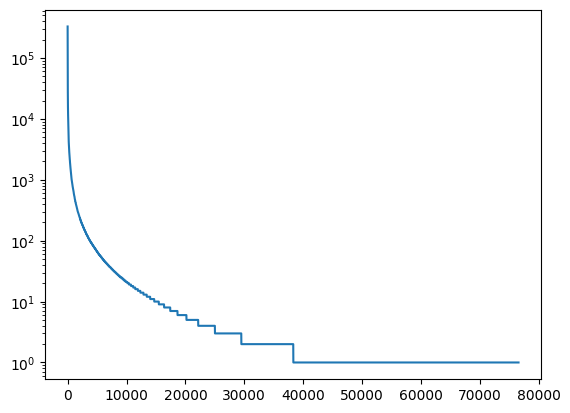

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

# Корпус вже токенізовано в all_tokens та all_tokens_stemmed
assert all_tokens
assert all_tokens_stemmed

# Злічимо усі токени
token_counts = Counter(all_tokens_stemmed)

# Подивимося на 50 найчастотніших токенів
most_common = token_counts.most_common(50)

most_common_count = sum(count for token, count in most_common)
all_count = sum(token_counts.values())
print(f"Top {len(most_common)} most common tokens account for {most_common_count / all_count:%} of tokens")
print(f"Top {len(most_common)} tokens are: {most_common}")

# Розподіл токенів за частотою
plt.yscale("log")
plt.plot(sorted(token_counts.values(), reverse=True))


Щоб краще уявити собі нерівномірність цього розподілу, намалюємо його на лінійній, а не логаріфмічній шкалі:

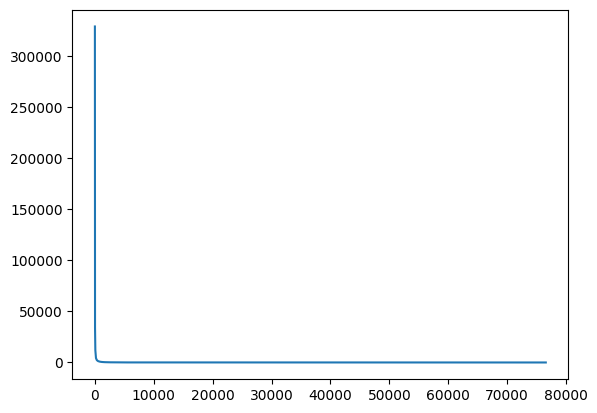

In [ ]:
plt.plot(sorted(token_counts.values(), reverse=True))

#### 2.5.2 Рідковживані слова

Залишимо лише ті слова, які зустрічаються щонайменше 5 разів. Також візьмемо `VOCAB_SIZE` найчастотніших слів.

In [ ]:
VOCAB_SIZE = 5000
MIN_COUNT = 5

print(f"Vocab size before filtering: {len(token_counts):,}")

vocab_list = [token for token, count in token_counts.most_common()
              if count > MIN_COUNT
              and token not in STOP_WORDS]

print(f"Vocab size after filtering: {len(vocab_list):,}")

# Зараз vocab містить токени, відсортовані за частотою у порядку зменшення.
# Візьмемо лише частину з них
vocab_list = vocab_list[:VOCAB_SIZE]
print(f"Final vocab size: {len(vocab_list):,}")

Vocab size before filtering: 76,570
Vocab size after filtering: 20,152
Final vocab size: 5,000


In [ ]:
# Приклад токенів у словнику
vocab_list[4090:4100]

['bump',
 'molli',
 'profess',
 'cannon',
 'furi',
 'frankenstein',
 'crucial',
 'sue',
 'lang',
 'damon']

#### 2.5.3 Допоміжні функції

Є кілька операцій, які часто доводиться робити із словником:

- Отримати слово за його індексом
- Отримати індекс за словом

До того ж доводиться враховувати, що токена може й не бути в словнику. У такому випадку зазвичай повертається спеціальний токен `<unk>`.

Нижче ми загорнемо всі ці домоміжні функції у клас `Vocabulary`. Різні бібліотеки і фреймворки мають свої аналоги цього класу. Для PyTorch це [`torchtext.Vocab`](https://pytorch.org/text/stable/vocab.html).

In [ ]:
class Vocabulary:

  def __init__(self, tokens, unk_token="<unk>"):
    self.unk_token = unk_token
    self.unk_index = 0
    self._itos = [unk_token] + tokens
    self._stoi = {token: index for index, token in enumerate(self._itos)}

  def stoi(self, token: str) -> int:
    """Return token index or `<unk>` index if `token` is not in the vocab.
    """
    return self._stoi.get(token, self.unk_index)


  def itos(self, index: int) -> str:
    """Return token by its `index`.

    Raise LookupError if `index` is out of vocabulary range.
    """

    return self._itos[index]

  @property
  def tokens(self):
    return self._itos

  def __len__(self) -> int:
    return len(self._itos)


vocab = Vocabulary(vocab_list)
print(f"Index of `dog` is {vocab.stoi('dog')}")
print(f"Token #42 is `{vocab.itos(42)}`")

Index of `dog` is 753
Token #42 is `what`


Токени, яких немає в словнику, предсталяються спеціальним токеном `<unk>` (має індекс 0):

In [ ]:
s = "Hello NULP !".split()
[vocab.stoi(x.lower()) for x in s]

[4240, 0, 26]

# 3 Представлення тексту

## 3.1 One-hot

При one-hot кодуванні кожне слово представляється вектором, довжина якого дорівнює розміру словника. У цьому векторі всі елементи, крім одного, дорівнюють нулю. Єдина одиниця відповідає позиції слова у словнику.


In [ ]:
def one_hot(token: str, vocab: Vocabulary) -> List[int]:
    # Створюємо список нулів довжиною, що дорівнює розміру словника
    result = [0] * len(vocab)

    # Отримуємо індекс токена (слова) у словнику
    index = vocab.stoi(token)

    # Встановлюємо 1 на позиції, що відповідає індексу токена
    result[index] = 1

    return result

In [ ]:
# Закодуємо слово "dog"
vector_dog = one_hot("dog", vocab)

# Перевіряємо довжину вектора (вона повинна дорівнювати розміру словника)
len(vector_dog)

5001

In [ ]:
# Виводимо перші 20 елементів вектора. Вектор розріджений, містить багато нулів.
vector_dog[:20]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
# Знаходимо позицію слова "dog" у словнику
vector_dog.index(1)

753

In [ ]:
# Перевіряємо, чи правильно закодовано слово, декодуючи його індекс назад у слово
vocab.itos(751)

'dialog'

## 3.2 Bag-of-words

In [ ]:
def bag_of_words(tokens: List[str], vocab: Vocabulary) -> List[int]:
  result = [0] * len(vocab)

  for token in tokens:
    index = vocab.stoi(token)
    result[index] += 1

  return result

In [ ]:
tokens = preprocess("I like like turtles . . . ")
print(f"Tokenized: f{tokens}")
vector_text = bag_of_words(tokens, vocab)
print(vector_text)

Tokenized: f['i', 'like', 'like', 'turtl', '.', '.', '.']
[1, 0, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
bag_of_words(preprocess("turtles . . . like I like"), vocab)[:20]

[1, 0, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

## 3.3 N-grams


"don't like" -> do, n't, like

I like it very much

1-ngram: I, like, it, very, much

2-ngram: "I like", "like it"

3-ngram: "I like it", "like it very", "it very much"





In [ ]:
def extract_ngrams(tokens: List[str], max_n: int, min_n: int = 1) -> List[str]:
    """Extract n-grams from `s`.

    Args:
        tokens: list of tokens.
        min_n: Minimum length of n-gram to extract.
        max_n: Maximum length of n-gram to extract.

    Return:
        list of ngrams, where each ngram is as a string.


    Example:
        >>> extract_ngrams("Hello world !", 2)
        ['Hello', 'Hello world', 'world', 'world !', '!']

    """

    return list(extract_ngrams_iter(tokens, max_n, min_n))


def extract_ngrams_iter(tokens: List[str], max_n: int, min_n: int = 1) -> List[str]:
    """Extract all ngrams from `s`, yielding them one by one.

    Example:
        >>> next(extract_ngrams_iter("Hello world !", 2))
        'Hello'

    """

    for i in range(len(tokens)):
        for j in range(min_n, max_n + 1):
            if i + j <= len(tokens):
                ngram = tokens[i : i + j]
                ngram = " ".join(ngram)
                yield ngram


extract_ngrams("hello world !".split(), 2)

['hello', 'hello world', 'world', 'world !', '!']

In [ ]:
# Побудуємо н-грамний словник
counts = Counter()
for doc in tqdm(train_data):
  tokens = preprocess(doc["text"])
  ngrams = extract_ngrams(tokens, 2)
  counts.update(ngrams)

ngrams_vocab = [token for token, count in counts.most_common() if count > MIN_COUNT]
ngrams_vocab = ngrams_vocab[:VOCAB_SIZE]
ngrams_vocab = Vocabulary(ngrams_vocab)


100%|██████████| 25000/25000 [01:16<00:00, 327.35it/s]


In [ ]:
len(ngrams_vocab)

5001

In [ ]:
# Подивимося на приклади n-грам в нашому словнику:
[x for x in ngrams_vocab._itos ][1000:1020]

['respect',
 'say ,',
 '4',
 'know what',
 'british',
 '. fact',
 'i ll',
 'knew',
 'dialog',
 'intellig',
 'dog',
 'we have',
 'fact ,',
 'those who',
 'richard',
 'work .',
 'cheap',
 'non',
 'again ,',
 'four']

### 3.3.1 Bag-of-n-grams

In [ ]:
def bag_of_ngrams(tokens: List[str], vocab: Vocabulary) -> List[int]:
  result = [0] * len(vocab)
  ngrams = extract_ngrams(tokens, 2)
  for ngram in ngrams:
    index = vocab.stoi(ngram)
    result[index] += 1

  return result

In [ ]:
print(bag_of_ngrams(preprocess("I couldn't resist"), ngrams_vocab))

[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

## TF-IDF

TODO - написати (osyvokon)




## Feature hashing

Feature hashing, також відомий як hashing trick, - це альтернатива створенню повного словника всіх слів. Натомість цей метод використовує хеш-функцію, щоб перетворити слова на числові ознаки в заданному діапазоні (наприклад, від 0 до 5000). Хеш-функція без проблем приймає будь-які токени, знайомі та незнайомі. Більше того, словник тепер можна не зберігати. Такий підхід економить пам'ять і прискорює обробку даних.

Однак у feature hashing є свої недоліки. Головний з них - можливість колізій, коли різні слова потрапляють в один індекс вектора. Крім того, отримані вектори важко інтерпретувати, оскільки кожен індекс не відповідає конкретному слову.

Загалом, feature hashing зараз використовується рідко. Переважно, у випадках, коли потрібен абсолютно мінімальний розмір моделі та швидкість. Наприклад, модель визначення мови веб-сторінки, вбудована в Google Chrome, важила менше одного мегабайта й була здатна визначати близько ста мов завдяки трюку з хешуванням ознак.

In [ ]:
from hashlib import md5

def bag_of_hashed_ngrams(ngrams: List[str], vocab_size) -> List[int]:
    result = [0] * vocab_size
    for ngram in ngrams:
        ngram_hash = md5(ngram.encode()).digest()
        index = int.from_bytes(ngram_hash, byteorder='big') % vocab_size
        result[index] += 1
    return result

In [ ]:
bag_of_hashed_ngrams(["hello", "world"], vocab_size=10)

[0, 1, 0, 0, 1, 0, 0, 0, 0, 0]

# 4 Класифікація тексту

## Векторизація даних

In [ ]:
import numpy as np


def vectorize(data: 'datasets.Dataset') -> Tuple[np.array, np.array]:
  X_list = []
  y_list = []
  for doc in data:
    tokens = preprocess(doc["text"])
    X_list.append(bag_of_ngrams(tokens, ngrams_vocab))
    y_list.append(doc["label"])  # 0 or 1
  X = np.array(X_list)
  y = np.array(y_list)
  return (X, y)

# Take random 2000 documents for a dev set
valid_data = imdb["test"].shuffle(seed=1).filter(lambda x, i: i < 2000, with_indices=True)

X_train, y_train = vectorize(train_data)
X_val, y_val = vectorize(valid_data)




In [ ]:
X_train.shape
X_val

array([[ 32,   1,   3, ...,   0,   0,   0],
       [133,   6,   7, ...,   0,   0,   0],
       [144,   8,  12, ...,   0,   0,   0],
       ...,
       [188,  10,  16, ...,   0,   0,   0],
       [ 54,   5,   5, ...,   0,   0,   0],
       [219,  11,  19, ...,   0,   0,   0]])

## Тренування моделі

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='liblinear', C=0.5, penalty="l1")
model.fit(X_train, y_train)

LogisticRegression(C=0.5, penalty='l1', solver='liblinear')


## Оцінка моделі

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

def evaluate(model):
  y_hat = model.predict(X_val)
  accuracy = (y_hat == y_val).mean()

  return {
      "accuracy": accuracy,
      "precision": precision_score(y_val, y_hat),
      "recall": recall_score(y_val, y_hat),
      "f1": f1_score(y_val, y_hat),
  }

metrics = evaluate(model)
print(f"Log regression: {metrics}")

Log regression: {'accuracy': 0.8785, 'precision': 0.861271676300578, 'recall': 0.9003021148036254, 'f1': 0.880354505169867}


In [ ]:
!pip install --quiet scikit-plot==0.3.3


  Preparing metadata (setup.py) ... done


In [ ]:
!pip install scipy==1.9.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.7/33.7 MB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 25.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: scipy
    Found existing installation: scipy 1.11.4
    Uninstalling scipy-1.11.4:
      Successfully uninstalled scipy-1.11.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 1.4.15 requires scipy>=1.10.0, but you have scipy 1.9.3 which is incompatible.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is inco

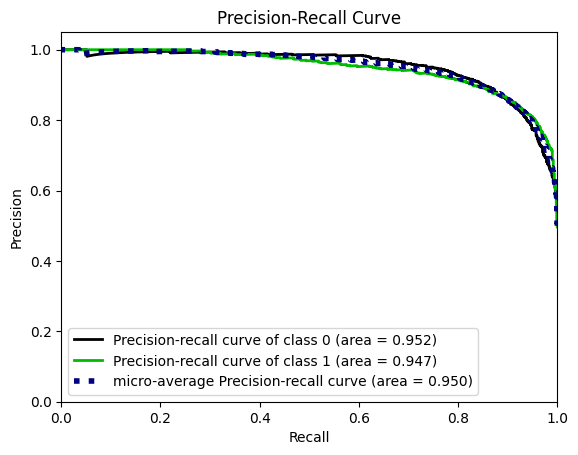

In [ ]:
import scikitplot as skplt
import matplotlib.pyplot as plt

y_probas = model.predict_proba(X_val)
skplt.metrics.plot_precision_recall_curve(y_val, y_probas)
plt.show()

In [ ]:
def predict(text: str, model: 'BaseEstimator') -> float:
  tokens = preprocess(text)
  features = bag_of_ngrams(tokens, ngrams_vocab)
  features = np.array([features])
  prob_neg, prog_pos = model.predict_proba(features)[0]
  return prog_pos

In [ ]:
threshold = 0.5
predict("I liked that movie!", model) > threshold

True

In [ ]:
predict("The movie is terrible ", model) > threshold

False

# 5 scikit-learn

До цього моменту ми власноруч писали функції для препроцесінгу даних. Це добре для навчання, але в реальності використовують готові імплементації.

Наприклад, клас [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) з пакету scikit-learn вміє робити майже все з написаного нами:

In [ ]:
import datasets
dataset = datasets.load_dataset('imdb')
train_data = dataset['train']
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(
    max_features=1000,
    ngram_range=(1,3),
    binary=False,
    stop_words=STOP_WORDS,
    # vocabulary=vocab.tokens,
    )
X_train = vectorizer.fit_transform(train_data[:]["text"])

In [ ]:
X_train

<25000x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 2034128 stored elements in Compressed Sparse Row format>

In [ ]:
vectorizer.get_feature_names_out()

array(['10', '20', 'able', 'about', 'about movie', 'above', 'absolutely',
       'across', 'act', 'acted', 'acting', 'action', 'actor', 'actors',
       'actress', 'actual', 'actually', 'add', 'after', 'again',
       'against', 'age', 'ago', 'all', 'all time', 'almost', 'alone',
       'along', 'already', 'also', 'although', 'always', 'am', 'amazing',
       'america', 'american', 'among', 'an', 'animation', 'annoying',
       'another', 'any', 'anyone', 'anything', 'anyway', 'apparently',
       'appears', 'aren', 'around', 'art', 'at', 'at all', 'at end',
       'at least', 'at time', 'at times', 'atmosphere', 'attempt',
       'attention', 'audience', 'average', 'avoid', 'away', 'away from',
       'awful', 'baby', 'back', 'bad', 'badly', 'based', 'based on',
       'basically', 'be', 'beautiful', 'became', 'because', 'become',
       'becomes', 'been', 'before', 'begin', 'beginning', 'begins',
       'behind', 'being', 'believable', 'believe', 'best', 'better',
       'better than

In [ ]:
from sklearn.linear_model import LogisticRegression
model2 = LogisticRegression(solver='liblinear', C=0.1, penalty="l1")
model2.fit(X_train, train_data["label"])

LogisticRegression(C=0.1, penalty='l1', solver='liblinear')

In [ ]:
from sklearn.metrics import accuracy_score

valid_data = dataset["test"].shuffle(seed=1).filter(lambda x, i: i < 2000, with_indices=True)
X_valid = vectorizer.transform(valid_data["text"])
y_valid = valid_data["label"]

y_pred = model2.predict(X_valid)
accuracy_score(y_valid, y_pred)

0.853

## TF-IDF with sklearn

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1,2),
    # binary=True,
    # stop_words='english',
    # vocabulary=vocab.tokens,
    )
X_train = vectorizer.fit_transform(train_data[:]["text"])

model3 = LogisticRegression(solver='liblinear', C=0.2, penalty="l1")
model3.fit(X_train, train_data["label"])


X_valid = vectorizer.transform(valid_data["text"])
y_valid = valid_data["label"]
y_pred = model3.predict(X_valid)
accuracy_score(y_valid, y_pred)

0.835